In [3]:
import multiprocess as mp
from os import getpid
import numpy as np
from time import time

# Random walks

In [4]:
import networkx as nx
import numpy as np

In [5]:
def simple_2d_random_walk(G, L, max_steps, start_node=(0,0), use_random_starting_node=False):
    '''
    Perform a simple random walk on a given graph G, which should be based on a 2d lattice.
    In one step the random walker with equal probability traverses any of the incident edges 
    of the current node to a neighboring node. 
    
    Arguments:
    - G: graph, based on a 2d lattice
    - L: side length L of the 2d lattice base of G
    - max_steps: number of steps the random walker takes in total
    - start_node: node to start random walk from, default=(0,0)
    - use_random_starting_node: start on a randomly chosen node, default=False
    
    Return:
    - path: list of edges the random walker traversed (format: [(node1, node2), (node2, node3)])
    '''
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # randomly choose from neighbors of current node
        new_node = tuple(np.random.permutation(list(G[current_node].keys()))[0])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
    return path


def lazy_2d_random_walk(G, L, max_steps, start_node=(0,0), use_random_starting_node=False):
    '''
    Perform a lazy random walk on a given graph G, which should be based on a 2d lattice.
    In one step the random walker stays at the current node with probability 1/2 and with 
    probability 1/2d_n traverses any of the d_n incident edges of the current node to a 
    neighboring node. 
    
    Arguments:
    - G: graph, based on a 2d lattice
    - L: side length L of the 2d lattice base of G
    - max_steps: number of steps the random walker takes in total
    - start_node: node to start random walk from, default=(0,0)
    - use_random_starting_node: start on a randomly chosen node, default=False
    
    Return:
    - path: list of edges the lazy random walker traversed (format: [(node1, node2), (node2, node3)])
    '''
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # stay at current node with p=1/2 or move to a neighboring 
        # node with each p=1/2d_n (d_n degree of current node)
        if np.random.uniform(0,1) <= 0.5:
            new_node = current_node
        else:
            new_node = tuple(np.random.permutation(list(G[current_node].keys()))[0])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
    return path

In [6]:
def get_some_paths(G, L, T, M=1000, use_random_starting_node=False, random_walk_function=simple_2d_random_walk):
    # walks
    max_steps = T
    max_walks = M

    # paths[0] = path0, paths[1] = path1, ... 
    # paths[:,i] = nodes of all walks after i-1 steps (dim = (max_walks, max_steps))
    iter_list = np.random.permutation(np.arange(0, max_walks)).tolist()
    for i in range(max_walks):
        path_i = np.array(random_walk_function(G, L, max_steps, use_random_starting_node=use_random_starting_node))[np.newaxis,:,1]
        if i == 0:
            paths = path_i
        else:
            paths = np.concatenate((paths, path_i))
    return paths


def get_some_paths_parallel(G, L, T, M=1000, use_random_starting_node=False, random_walk_function=simple_2d_random_walk):
    # walks
    max_steps = T
    max_walks = M

    # paths[0] = path0, paths[1] = path1, ... 
    # paths[:,i] = nodes of all walks after i-1 steps (dim = (max_walks, max_steps))
    pool = mp.Pool(4)
    iter_list = np.random.permutation(np.arange(0, max_walks)).tolist()
    #paths = np.array([pool.apply(random_walk_function, args=(G, L, max_steps)) for i in range(max_walks)])[:,:,1]    # apply
    paths = np.array(pool.starmap(random_walk_function, [(G, L, max_steps, (0,0), use_random_starting_node) for i in iter_list]))[:,:,1]    # starmap
    #paths = np.array(pool.starmap_async(random_walk_function, [(G, L, max_steps) for i, bla_i in enumerate(range(max_walks))]).get())[:,:,1]    # starmap_async
    
    pool.close()
    
    return paths

In [7]:
L = 20
G = nx.grid_2d_graph(L, L, periodic=True)
max_steps = int(2e2)
max_walks = int(1e2)

# seed
#np.random.seed(42)
# parallel
tic = time()
paths_parallel = get_some_paths_parallel(G, L, T=max_steps, M=max_walks, random_walk_function=lazy_2d_random_walk)
toc = time()
print("Parallel: {:.2f} sec".format(toc-tic))

# seed
#np.random.seed(42)
# simple
tic = time()
paths_simple = get_some_paths(G, L, T=max_steps, M=max_walks, random_walk_function=lazy_2d_random_walk)
toc = time()
print("Simple:   {:.2f} sec".format(toc-tic))

Parallel: 1.26 sec
Simple:   0.48 sec


In [8]:
def prob_distribution_alt(paths, T):
    num_steps = T
    prob, bins = np.histogram(a=paths[:,num_steps,0]*L + paths[:,num_steps,1], bins=np.arange(0,L*L+1), density=True)
    return prob


def L1_norm(prob1, prob2):
    norm = 0.5 * np.sum(abs(prob1-prob2))
    return norm

In [9]:
import matplotlib.pyplot as plt

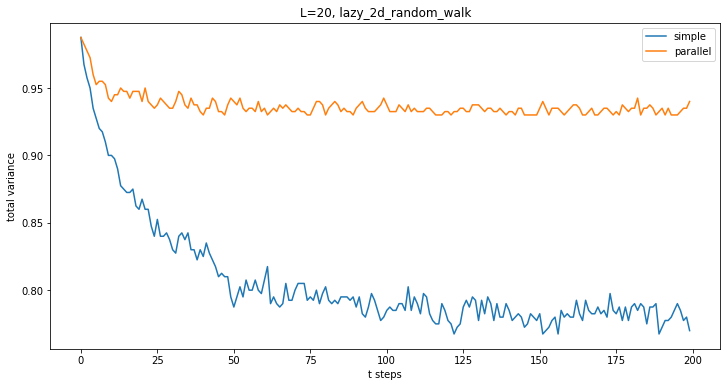

In [10]:
norm_vector1 = []
norm_vector2 = []
for T in range(max_steps):
    prob1=prob_distribution_alt(paths_simple, T)
    prob2=prob_distribution_alt(paths_parallel, T)
    # L1 norm using node distribution from random walks and stationary distriubtion
    # pi_v = d_v/(2*E), with d_v the degree of vertex/node v. For the periodic
    # lattice d_v=4 and hence pi_v = 1/ #nodes_in_G = 1/L*L
    norm_vector1.append(L1_norm(prob1, np.ones(prob1.shape[0])/(L*L)))
    norm_vector2.append(L1_norm(prob2, np.ones(prob2.shape[0])/(L*L)))

fig1, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(norm_vector1, label="simple")
ax1.plot(norm_vector2, label="parallel")
ax1.plot()

ax1.set_title('L={}, lazy_2d_random_walk'.format(L))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
ax1.legend()
#plt.ylim(-0.01,0.1)
plt.show()